In [183]:
import math 
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
from matplotlib import pyplot as plt
from pylab import rcParams #runtime configuration param
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
%matplotlib inline

In [184]:
data = pd.read_csv('data/VTI.csv', sep=",")

In [185]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-25,107.510002,107.660004,107.250000,107.470001,101.497200,1820300
1,2015-11-27,107.589996,107.760002,107.220001,107.629997,101.648300,552400
2,2015-11-30,107.779999,107.849998,107.110001,107.169998,101.213867,3618100
3,2015-12-01,107.589996,108.209999,107.370003,108.180000,102.167740,2443600
4,2015-12-02,108.099998,108.269997,106.879997,107.050003,101.100533,2937200


In [186]:
data.shape

(755, 7)

In [187]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [188]:
#convert data col into datatime
data.loc[:,'Date'] = pd.to_datetime(data['Date'],format= '%Y-%m-%d')

In [189]:
# change all col headings into lower and remove space
data.columns = [str(x).lower().replace(' ','_') for x in data.columns]

In [190]:
# get month

data['month'] = data['date'].dt.month

In [191]:
#sort by datetime
data.sort_values(by = 'date', inplace=True, ascending= True)

In [192]:
data.head()

,date,open,high,low,close,adj_close,volume,month
0,2015-11-25,107.510002,107.660004,107.250000,107.470001,101.497200,1820300,11
1,2015-11-27,107.589996,107.760002,107.220001,107.629997,101.648300,552400,11
2,2015-11-30,107.779999,107.849998,107.110001,107.169998,101.213867,3618100,11
3,2015-12-01,107.589996,108.209999,107.370003,108.180000,102.167740,2443600,12
4,2015-12-02,108.099998,108.269997,106.879997,107.050003,101.100533,2937200,12


In [193]:
rcParams['figure.figsize'] = 10,8 

Text(0, 0.5, 'USD')

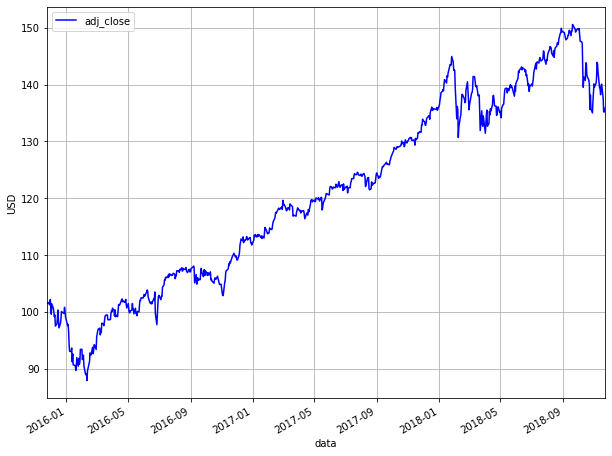

In [194]:
ax = data.plot(x='date', y = 'adj_close', style = 'b-', grid = True)
ax.set_xlabel('data')
ax.set_ylabel('USD')

In [195]:
data['range_high_low'] = data['high'] - data['low']
data.drop(['high','low'], axis = 1, inplace = True)

In [196]:
data['range_open_close'] = data['open'] - data['close']
data.drop(['open','close'], axis = 1, inplace = True)

In [197]:
data.head()

,date,adj_close,volume,month,range_high_low,range_open_close
0,2015-11-25,101.497200,1820300,11,0.410004,0.040001
1,2015-11-27,101.648300,552400,11,0.540001,-0.040001
2,2015-11-30,101.213867,3618100,11,0.739997,0.610001
3,2015-12-01,102.167740,2443600,12,0.839996,-0.590004
4,2015-12-02,101.100533,2937200,12,1.390000,1.049995


In [198]:
data['order_day'] = [x for x in list(range(len(data)))]

merging_keys = ['order_day']

lag_cols = ['adj_close', 'range_high_low','range_open_close','volume']
lag_cols

['adj_close', 'range_high_low', 'range_open_close', 'volume']

In [199]:
N = 5
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = data[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    data = pd.merge(data, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
data = data[N:]
    
data.head()

<ipython-input-199-14e60c5ee055>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm_notebook(shift_range):


,date,adj_close,volume,month,range_high_low,range_open_close,order_day,adj_close_lag_1,range_high_low_lag_1,range_open_close_lag_1,...,range_open_close_lag_3,volume_lag_3,adj_close_lag_4,range_high_low_lag_4,range_open_close_lag_4,volume_lag_4,adj_close_lag_5,range_high_low_lag_5,range_open_close_lag_5,volume_lag_5
5,2015-12-03,99.589470,3345600,12,2.420005,1.840004,5,101.100533,1.390000,1.049995,...,0.610001,3618100.0,101.648300,0.540001,-0.040001,552400.0,101.497200,0.410004,0.040001,1820300.0
6,2015-12-04,101.421646,4520000,12,1.919998,-1.580001,6,99.589470,2.420005,1.840004,...,-0.590004,2443600.0,101.213867,0.739997,0.610001,3618100.0,101.648300,0.540001,-0.040001,552400.0
7,2015-12-07,100.628342,3000500,12,1.209999,0.680000,7,101.421646,1.919998,-1.580001,...,1.049995,2937200.0,102.167740,0.839996,-0.590004,2443600.0,101.213867,0.739997,0.610001,3618100.0
8,2015-12-08,100.023895,3149600,12,1.130005,0.029998,8,100.628342,1.209999,0.680000,...,1.840004,3345600.0,101.100533,1.390000,1.049995,2937200.0,102.167740,0.839996,-0.590004,2443600.0
9,2015-12-09,99.164467,4179800,12,2.269997,0.550003,9,100.023895,1.130005,0.029998,...,-1.580001,4520000.0,99.589470,2.420005,1.840004,3345600.0,101.100533,1.390000,1.049995,2937200.0


In [200]:
data.shape

(750, 27)

In [201]:
data.isnull().sum()

date                      0
adj_close                 0
volume                    0
month                     0
range_high_low            0
range_open_close          0
order_day                 0
adj_close_lag_1           0
range_high_low_lag_1      0
range_open_close_lag_1    0
volume_lag_1              0
adj_close_lag_2           0
range_high_low_lag_2      0
range_open_close_lag_2    0
volume_lag_2              0
adj_close_lag_3           0
range_high_low_lag_3      0
range_open_close_lag_3    0
volume_lag_3              0
adj_close_lag_4           0
range_high_low_lag_4      0
range_open_close_lag_4    0
volume_lag_4              0
adj_close_lag_5           0
range_high_low_lag_5      0
range_open_close_lag_5    0
volume_lag_5              0
dtype: int64

In [202]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 5 to 754
Data columns (total 27 columns):
date                      750 non-null datetime64[ns]
adj_close                 750 non-null float64
volume                    750 non-null int64
month                     750 non-null int64
range_high_low            750 non-null float64
range_open_close          750 non-null float64
order_day                 750 non-null int64
adj_close_lag_1           750 non-null float64
range_high_low_lag_1      750 non-null float64
range_open_close_lag_1    750 non-null float64
volume_lag_1              750 non-null float64
adj_close_lag_2           750 non-null float64
range_high_low_lag_2      750 non-null float64
range_open_close_lag_2    750 non-null float64
volume_lag_2              750 non-null float64
adj_close_lag_3           750 non-null float64
range_high_low_lag_3      750 non-null float64
range_open_close_lag_3    750 non-null float64
volume_lag_3              750 non-null float64
a

In [203]:
features = [
"adj_close_lag_1",
"range_high_low_lag_1",
"range_open_close_lag_1",
"volume_lag_1",
"adj_close_lag_2",
"range_high_low_lag_2",
"range_open_close_lag_2",
"volume_lag_2",
"adj_close_lag_3",
"range_high_low_lag_3",
"range_open_close_lag_3",
"volume_lag_3",
"adj_close_lag_4",
"range_high_low_lag_4",
"range_open_close_lag_4",
"volume_lag_4",
"adj_close_lag_5",
"range_high_low_lag_5",
"range_open_close_lag_5",
"volume_lag_5"
]

target = "adj_close"

# Get sizes of each of the datasets
num_cv = int(cv_size*len(data))
num_test = int(test_size*len(data))
num_train = len(data) - num_cv - num_test

# Split into train, cv, and test
train = data[:num_train]
cv = data[num_train:num_train+num_cv]
train_cv = data[:num_train+num_cv]
test = data[num_train+num_cv:]

# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (450, 20)
y_train.shape = (450,)
X_cv.shape = (150, 20)
y_cv.shape = (150,)
X_train_cv.shape = (600, 20)
y_train_cv.shape = (600,)
X_sample.shape = (150, 20)
y_sample.shape = (150,)


Text(0, 0.5, 'USD')

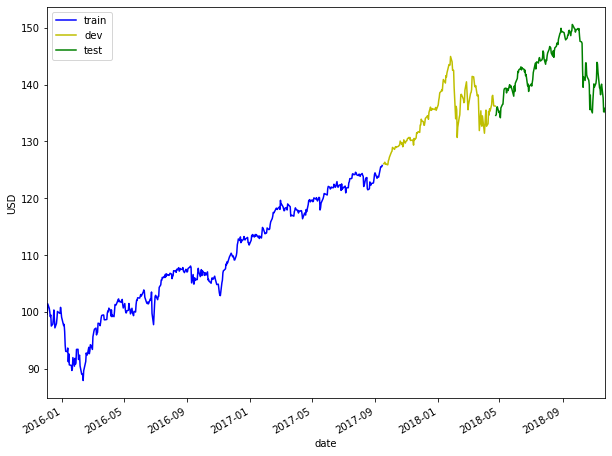

In [204]:
rcParams['figure.figsize'] = 10,8
ax = train.plot(x = 'date',y = 'adj_close', style = 'b-' )
ax = cv.plot(x='date', y='adj_close', style='y-', ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-',  ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")


In [208]:
n_estimators = 100            
max_depth = 3                 
learning_rate = 0.1           
min_child_weight = 1        
subsample = 1                 
colsample_bytree = 1          
colsample_bylevel = 1         
train_test_split_seed = 111    
model_seed = 10
# Create the model
model = XGBRegressor(seed=model_seed,
                      n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight)

# Train the regressor
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=10, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=10, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [209]:
estimation = model.predict(X_train)
math.sqrt(mean_squared_error(y_train,estimation))

0.43893765543211893

Text(0, 0.5, 'USD')

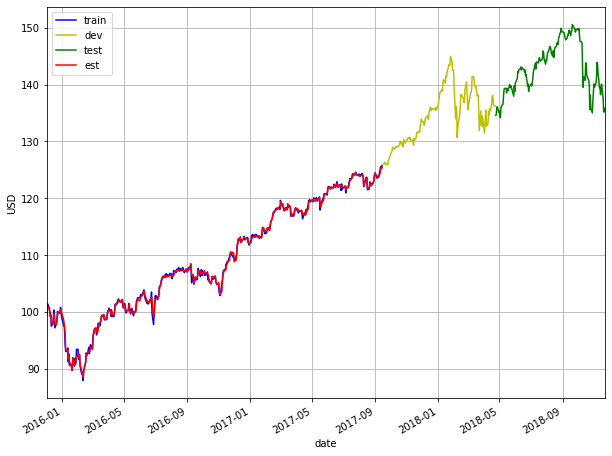

In [214]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': estimation, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [215]:

# Do prediction on test set
est = model.predict(X_cv)

# Calculate RMSE
print("RMSE = " + str(math.sqrt(mean_squared_error(y_cv, est))))

RMSE = 10.85748136678718


Text(0, 0.5, 'USD')

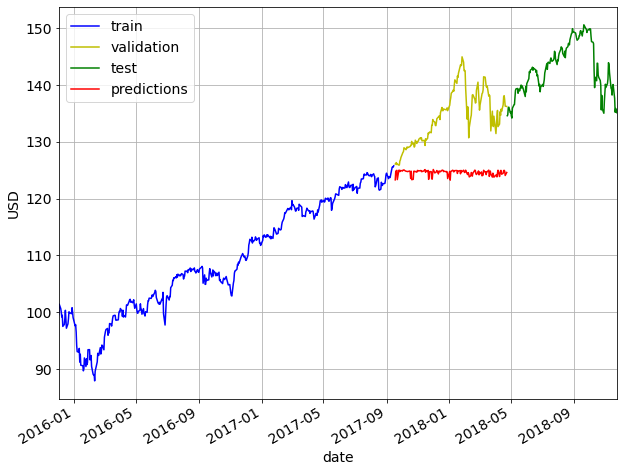

In [216]:

# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

est_df = pd.DataFrame({'est': est, 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")